# setup

In [1]:
import os
import sys

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, "..")))

import torch

from torchinfo import summary

import torchvision
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

import timm

import matplotlib.pyplot as plt
import numpy as np

from going_modular.going_modular.engine import trainVal, test_step, load_model_checkpoint, ensemble_test_step
from helper_functions import plot_loss_curves

from model_utils import load_cnn_model, set_seeds
from data_loader import create_dataloaders


/home/ma012/AlexServer/btc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

# Config

In [3]:
SEED = 42
NUM_WORKERS = 0 # os.cpu_count() 

BATCH_SIZE_32 = 32
BATCH_SIZE_16 = 16
BATCH_SIZE_8 = 8

EPOCHS_50 = 50
EPOCHS_25 = 25
EPOCHS_20 = 20
EPOCHS_15 = 15
EPOCHS_10 = 10

LR_0_00001 = 0.00001
LR_0_0001 = 0.0001
LR_0_1 = 0.1

LR_0_00005 = 0.00005
LR_0_05 = 0.05

LOG_CNN= "/home/ma012/AlexServer/log/cnn.txt"

DATASET_DIR = "/home/ma012/AlexServer/Dataset"


# SAVE_PATH = "/home/ma012/AlexServer/log/CNN/vgg16_32.pth"
# SAVE_PATH = "/home/ma012/AlexServer/log/CNN/MobileNet_V2_8.pth"
SAVE_PATH = "/home/ma012/AlexServer/log/CNN/resnet50_test.pth"

MODEL_CFG = "torchvision.VGG16_Weights.IMAGENET1K_V1"
# MODEL_CFG = "torchvision.MobileNet_V2_Weights.IMAGENET1K_V1"
# MODEL_CFG = "torchvision.GoogLeNet_Weights.IMAGENET1K_V1"
# MODEL_CFG = "torchvision.ResNet50_Weights.IMAGENET1K_V1"


NUM_CLASSES = 3
CLASS_NAMES = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

TRAIN_RATIO = 0.7
VAL_RATIO = 0.1
TEST_RATIO = 0.2

MEAN=[0.485, 0.456, 0.406]
STD=[0.229, 0.224, 0.225]

DEFAULT_SIZE = (256, 256)
CROP_SIZE = 224

DEFAULT_NORMALIZE = transforms.Normalize(mean=MEAN,std=STD)

DEFAULT_TRANSFORMS = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(DEFAULT_SIZE, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor(),
    DEFAULT_NORMALIZE
])

# Run

## Dataset

In [4]:
set_seeds(SEED)

train_loader, val_loader, test_loader = create_dataloaders(
    dataset_dir=DATASET_DIR,
    transform=DEFAULT_TRANSFORMS,
    batch_size= BATCH_SIZE_16,
    num_workers=NUM_WORKERS,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    seed=SEED
)

# len(train_loader)
# len(train_loader.dataset)
loss_fn = torch.nn.CrossEntropyLoss()


## Load Model

In [ ]:
model = load_cnn_model(MODEL_CFG, NUM_CLASSES)
                       
optimizer = torch.optim.Adam(model.parameters(), lr=LR_0_0001)

## Training

In [ ]:
results = trainVal(model, train_loader, val_loader, optimizer, loss_fn,
                    EPOCHS_25, DEVICE, SAVE_PATH,LOG_CNN)

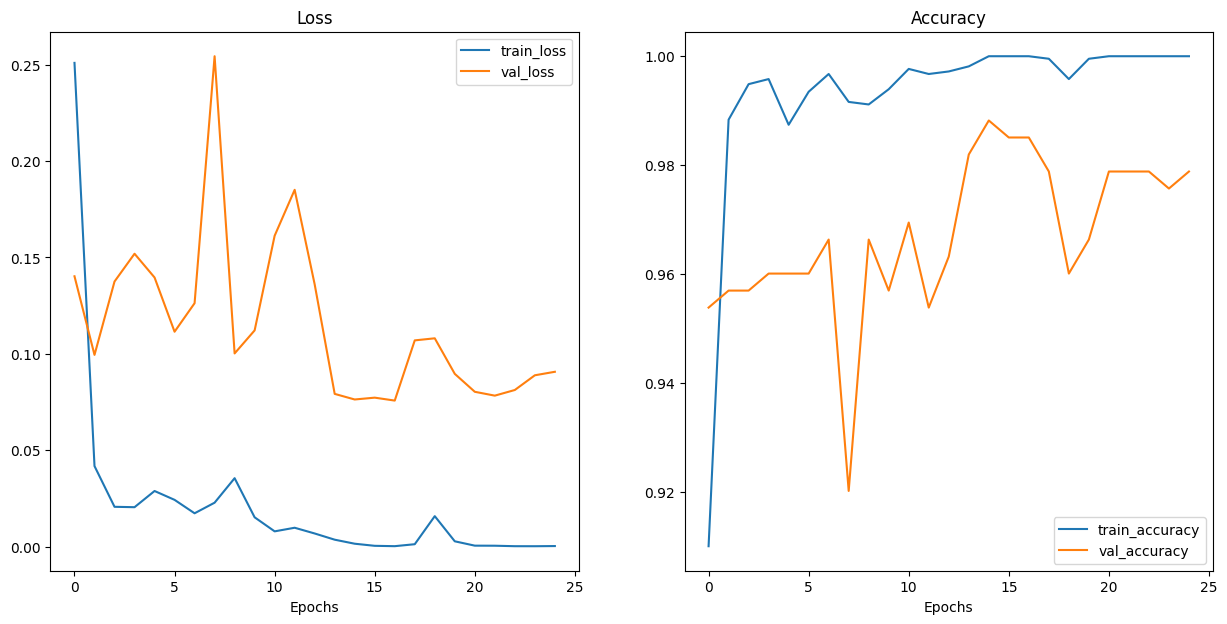

In [ ]:
plot_loss_curves(results, type="val")

In [ ]:
test_results = test_step(model, test_loader, loss_fn, DEVICE)
test_results

# Testing

In [5]:
checkpoint_model = [["/home/ma012/AlexServer/log/CNN/vgg16_8.pth","torchvision.VGG16_Weights.IMAGENET1K_V1"],
                    ["/home/ma012/AlexServer/log/CNN/MobileNet_V2_16.pth","torchvision.MobileNet_V2_Weights.IMAGENET1K_V1"],
                    ["/home/ma012/AlexServer/log/CNN/googlenet_8.pth","torchvision.GoogLeNet_Weights.IMAGENET1K_V1"],
                    ["/home/ma012/AlexServer/log/CNN/resnet50_16.pth","torchvision.ResNet50_Weights.IMAGENET1K_V1"]
                    ]

## Individual Test

In [9]:
model_name = ['VGG16','MobileNet_V2', 'GoogLeNet', 'ResNet50']

for idx, (cp_path, model_cfg) in enumerate(checkpoint_model):
    with open(LOG_CNN, "a", encoding="utf-8") as file:
        file.write(f"\n ======================   {model_name[idx]}  ==================================\n")

    model = load_cnn_model(model_cfg, NUM_CLASSES)
    model = load_model_checkpoint(model, cp_path, DEVICE)

    test_results = test_step(model, test_loader, loss_fn, DEVICE,LOG_CNN)

## Ensemble Test

In [6]:
models_list = []

for cp_path, model_cfg in checkpoint_model:
    # print(model_cfg)
    model = load_cnn_model(model_cfg, NUM_CLASSES)
    model = load_model_checkpoint(model, cp_path, DEVICE)
    
    models_list.append(model)

# CNN Ensemble Model

In [8]:
ensemble_loss, ensemble_acc , ensemble_sensitivity, ensemble_specificity = ensemble_test_step(models_list, test_loader, DEVICE,LOG_CNN)
print(f"Ensemble Test Loss: {ensemble_loss:.4f} | Ensemble Test Accuracy: {ensemble_acc:.4f}")
print(f"Ensemble sensitivity: {ensemble_sensitivity:.4f} | Ensemble specificity: {ensemble_specificity:.4f}")

Ensemble Test Loss: 0.0431 | Ensemble Test Accuracy: 0.9837
Ensemble sensitivity: 0.9847 | Ensemble specificity: 0.9922
